In [1]:
import sys

sys.path.append('../')
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# convert .jpg

In [1126]:
from AquaML.common.ImageTool import save_from_array

imgs = np.load('Square.npy')
save_from_array(imgs, 'Dataset/label2')

# Gray label

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F28FB464310>


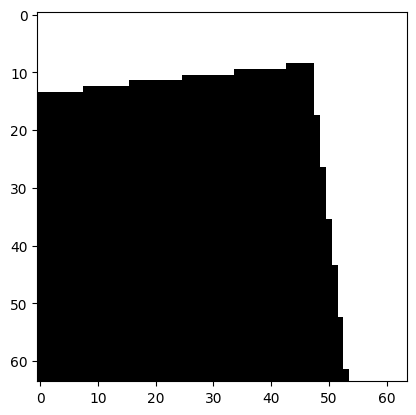

In [2]:
random_index = np.random.uniform(0, 100000, 1)
random_index = int(random_index)
random_index = 23198
img_label1 = Image.open('Dataset/label/{}.jpg'.format(str(random_index)))
print(img_label1)
img_label1_gray = np.array(img_label1)[:, :, 2]/255
img_label1_gray = np.where(img_label1_gray < 0.5, 0, 1)
plt.imshow(img_label1_gray, cmap='gray')

# process land zone

## pencil filter

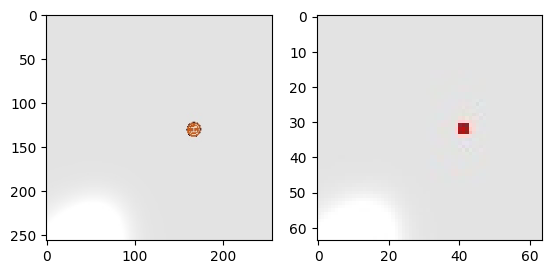

In [3]:
from AquaML.tool.CVFilter import PencilFilter

fil = PencilFilter(dilatation_size=2)
random_index = np.random.uniform(0, 30000, 1)
random_index = int(random_index)
# random_index = 23198
img_land = Image.open('Dataset/land2/{}.jpg'.format(random_index))
img_label = Image.open('Dataset/label2/{}.jpg'.format(str(random_index)))

img_label = np.array(img_label)
img_land = np.array(img_land)
# img_land1 = np.where(img_land1 > 200, 0, 255)
# res = fil.apply(img_land1)
plt.subplot(1,2,1)
plt.imshow(img_land)
plt.subplot(1,2,2)
plt.imshow(img_label)

# Resize texture

In [4]:
import cv2

for i in range(133):
    name = 'Dataset/texture/{}.png'.format(str(i))
    texture_img = Image.open(name)
    texture_img = np.array(texture_img)
    if texture_img.shape[0] != 256:
        texture_img = cv2.resize(texture_img,(256,256))
        cv2.imwrite(name, texture_img)

## Add texture

7677


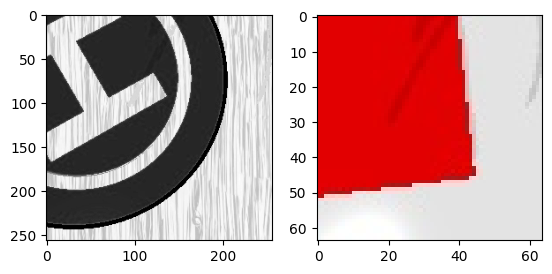

In [4]:
random_texture_index = np.random.uniform(0, 100, 1)
random_index = np.random.uniform(0, 30000, 1)
random_texture_index = int(random_texture_index)
random_index = int(random_index)
img_texture = Image.open('Dataset/texture/{}.png'.format(random_texture_index))
img_land = Image.open('Dataset/land2/{}.jpg'.format(random_index))
img_texture = np.array(img_texture)
img_land = np.array(img_land)
# plt.imshow(img_texture)
# img_mix_land = np.where(img_land[:, :, 0] > 200, img_texture, img_land)
img_mix_index = np.where(img_land[:, :, 2] > 200)
img_land[img_mix_index[0], img_mix_index[1],  :] = img_texture[img_mix_index[0],  img_mix_index[1],  :]
# img_land = fil.apply(img_land)
img_land = img_land/255
img_land = 0.9*img_land[:,:,2]+0.05*img_land[:,:,0]+0.05*img_land[:,:,1]
img_label = Image.open('Dataset/label2/{}.jpg'.format(str(random_index)))
img_label = np.array(img_label)
print(random_index)
# print(img_mix_index)
plt.subplot(121)
plt.imshow(img_land, cmap='gray')
plt.subplot(122)
plt.imshow(img_label)

# Batch processing

In [5]:
def plot_dual(img_as, img_bs, cmap=None):
    """ plot dual imgs, left is proceessing img, 
        right is origin img.

    Args:
        img_as (list): 1xwxhxchannel
        img_bs (list): 
    """
    length = len(img_as)

    cols = length

    for i in range(length):
        plt.subplot(cols,2,2*i+1)
        plt.imshow(img_as[i][0], cmap=cmap)
        plt.subplot(cols,2,2*i+2)
        plt.imshow(img_bs[i][0], cmap=cmap)

def add_texture(img,texture):
    change_index = np.where(img[:, :, 2] > 200)
    img[change_index[0], change_index[1],:] = texture[change_index[0], change_index[1],:]
    return img

def gray_scale_img(img):
    img = img/255
    img = 0.9*img[:,:,2]+0.05*img[:,:,0]+0.05*img[:,:,1]
    return img

def get_batch_data(batch):
    batch_index = np.random.uniform(0,30000,batch)
    batch_index = batch_index.astype(np.int32)

    batch_texture_index = np.random.uniform(0,100,batch)
    batch_texture_index = batch_texture_index.astype(np.int32)

    # print(batch_index)

    features = []
    labels = []
    for i, value in enumerate(batch_index):
        # print(value)
        feature = Image.open('Dataset/land2/{}.jpg'.format(value))
        label = Image.open('Dataset/label2/{}.jpg'.format(value))
        texture = Image.open('Dataset/texture/{}.png'.format(batch_texture_index[i]))

        feature = np.array(feature)
        label = np.array(label)
        texture = np.array(texture)

        feature = add_texture(feature, texture)
        feature = gray_scale_img(feature)

        label = label[:,:,2]/255
        label = np.expand_dims(label, axis=2)
        feature = np.expand_dims(feature, axis=2)
        # print(label.shape)
        # print(feature.shape)

        features.append(np.expand_dims(feature, axis=0))
        labels.append(np.expand_dims(label, axis=0))
    
    return features, labels

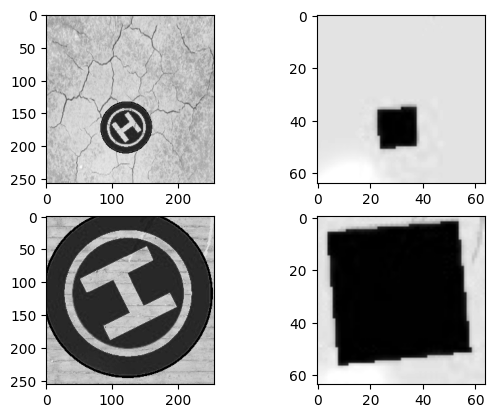

In [97]:
features, labels = get_batch_data(2)

plot_dual(features, labels, 'gray')

# VQ-VAE

## VQ layer

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for k in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[k], True)
        print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
    else:
        print("Not enough GPU hardware devices available")


memory growth: True
Not enough GPU hardware devices available


In [41]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        a = tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
        b = tf.reduce_sum(self.embeddings ** 2, axis=0)
        c = 2 * similarity
        distances = a+b-c

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

## Encoder

In [42]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(256,256,1))
    x = layers.Conv2D(64,3,strides=2, activation='relu',padding='same')(encoder_inputs)
    x = layers.Conv2D(64,3,strides=2,activation='relu', padding='same')(x)
    x = layers.Conv2D(128,3,strides=2,activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2D(256,3,strides=2,activation='relu',padding='same')(x)
    encoder_outputs = layers.Conv2D(latent_dim, 3, padding='same')(x)

    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

encoder = get_encoder()

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_52 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 conv2d_53 (Conv2D)          (None, 8, 8, 16)          3688

## Decoder

In [43]:
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(32,2, padding='same')(latent_inputs)
    x = layers.Conv2DTranspose(16,3,strides=2,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(16, 3,strides=2,activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(8,3,strides=2,activation='relu', padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1,3,activation='sigmoid', padding='same')(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder = get_decoder()

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 8, 8, 16)]        0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 8, 8, 32)         2080      
 Transpose)                                                      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 16, 16, 16)       4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 32, 32, 16)       2320      
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 64, 64, 8)        1160      
 Transpose)                                                

In [44]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(256, 256, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

In [45]:
get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 8, 8, 16)          591056    
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         10257     
                                                                 
Total params: 602,337
Trainable params: 602,337
Non-trainable params: 0
_________________________________________________________________


In [46]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, optimizer, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

        self.optimizer = optimizer

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                    tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    # @tf.function
    def train(self,features_i,labels_i, train_variance):
        with tf.GradientTape() as tape:
            reconstructions = self.vqvae(features_i)
            reconstruction_loss = (
                    tf.reduce_mean((labels_i - reconstructions) ** 2) / train_variance
            )

            total_loss = reconstruction_loss + sum(self.vqvae.losses)
        
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

## train loop

In [211]:
from tqdm import tqdm, trange
def train(trainer,epoch=100):
    loss = []
    for i in trange(epoch):
        features, labels = get_batch_data(64)
        features = np.vstack(features)
        labels = np.vstack(labels)
        var = np.var(labels)

        train_variance = tf.cast(var,dtype=tf.float32)

        tf_features = tf.cast(features, dtype=tf.float32)
        tf_labels = tf.cast(labels, dtype=tf.float32)
        info = trainer.train(tf_features, tf_labels, train_variance)

        loss.append(info['loss'])

        # print("--------------epoch:{}----------------".format(i+1))
        # for key, value in info.items():
        #     print("{}:{}".format(key, value))
    plt.plot(loss)

In [470]:
optimizer = keras.optimizers.Adam(learning_rate=2e-4)
vqvae_trainer = VQVAETrainer(1,optimizer,32)

In [471]:
vqvae_trainer.vqvae.load_weights('model/trans1.h5')

100%|██████████| 2000/2000 [12:57<00:00,  2.57it/s]


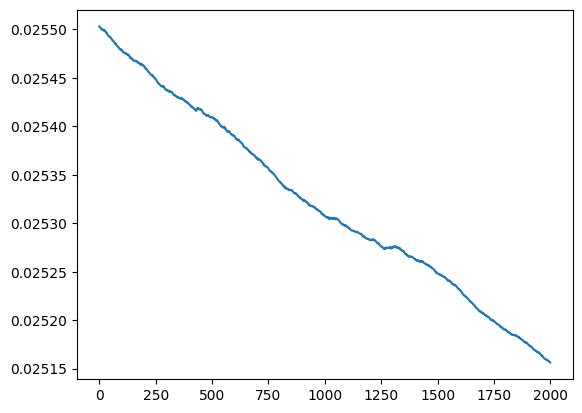

In [583]:
train(vqvae_trainer,2000)

## Test model

In [50]:
def get_test_batch_data(batch):
    batch_index = np.random.uniform(0,30000,batch)
    batch_index = batch_index.astype(np.int32)

    batch_texture_index = np.random.uniform(100,130,batch)
    batch_texture_index = batch_texture_index.astype(np.int32)

    # print(batch_index)

    features = []
    labels = []
    for i, value in enumerate(batch_index):
        # print(value)
        feature = Image.open('Dataset/land2/{}.jpg'.format(value))
        label = Image.open('Dataset/label2/{}.jpg'.format(value))
        texture = Image.open('Dataset/texture/{}.png'.format(batch_texture_index[i]))

        feature = np.array(feature)
        label = np.array(label)
        texture = np.array(texture)

        feature = add_texture(feature, texture)
        feature = gray_scale_img(feature)

        label = label[:,:,2]/255
        label = np.expand_dims(label, axis=2)
        feature = np.expand_dims(feature, axis=2)
        # print(label.shape)
        # print(feature.shape)

        features.append(np.expand_dims(feature, axis=0))
        labels.append(np.expand_dims(label, axis=0))
    
    return features, labels

In [452]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() * 255)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    img = np.where(reconstructed * 255 > 150, 255, 0)
    plt.imshow(img)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

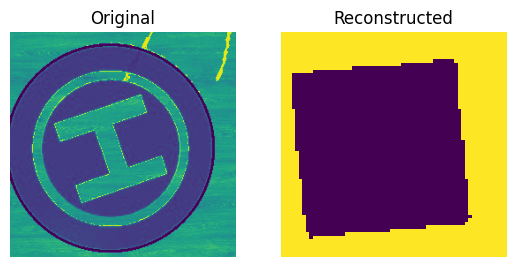

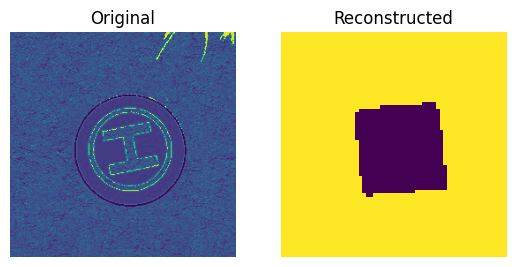

In [646]:
trained_vqvae_model = vqvae_trainer.vqvae
test_imgs, test_labels = get_test_batch_data(2)
test_imgs = np.vstack(test_imgs)
test_labels = np.vstack(test_labels)

reconstructions_test = trained_vqvae_model.predict(test_imgs)

for test_image, reconstructed_image in zip(test_imgs, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

## visualize codebook

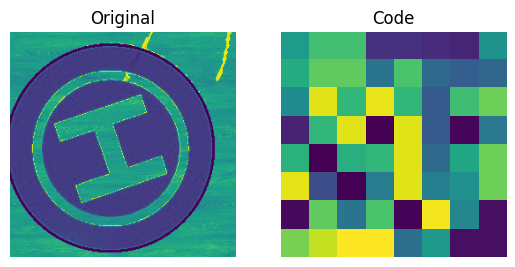

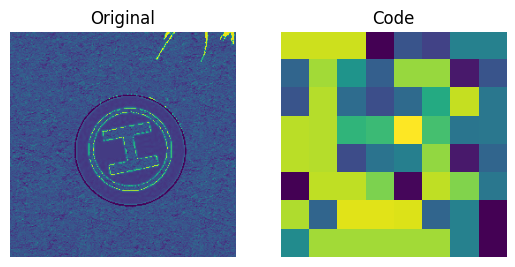

In [647]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_imgs)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_imgs)):
    plt.subplot(1, 2, 1)
    # test_img = np.where((test_images[i].squeeze() + 0.5) * 255, 100, 255, 0)
    plt.imshow(test_imgs[i] * 255)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    # codebook = np.where(codebook_indices[i] * 255>150, 255, 0)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [648]:
trained_vqvae_model.save_weights('model/trans3.h5')